# Violence Detection using CNN + LSTM neural network

Author: Oai Vu 

Created: 03/01/2022

Last modified: 13/01/2022

Some parts of the notebook refer to the one by Pedro.F Rodenas at [Pedro.F Rodenas](https://github.com/pedrofrodenas). A million thanks to him!!!

I have modified some Pedro's code and added new code to meet my needs

## Imports

In [29]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py
import shutil
import zipfile
from sklearn.metrics import classification_report

## Prepare the dataset

### Download and split the dataset

Mount to Google Drive and download the datasets from there. There are three datasets available including Hockey_Fights, Movies_Fights and Violent_Flow. 

The datasets have already been splitting into training and testing sets of 80% and 20% of them, respectively. The exact video names used for training and testing of each dataset can be found in the .txt files

In [30]:
# mount to google drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
# this is because some commands does not work due to the space of "My Drive"
!ln -s /content/gdrive/My\ Drive/ /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [32]:
# copy the three splitted datasets Movies_Fights, Hockey_Fights and Violent_Flow into content/
%cp /mydrive/AIFinalProject_Group1/SplittedDataset.zip content/

In [33]:
%ls
%cd content/

bin/      dev/   lib32/  mydrive@     root/  sys/                usr/
boot/     etc/   lib64/  opt/         run/   tensorflow-1.15.2/  var/
content/  home/  media/  proc/        sbin/  tmp/
datalab/  lib/   mnt/    python-apt/  srv/   tools/
/content


In [34]:
!unzip SplittedDataset.zip
!rm SplittedDataset.zip

Archive:  SplittedDataset.zip
 extracting: hockey_fights.zip       
 extracting: movies_fights.zip       
 extracting: violent_flow.zip        


### Choose the dataset for use

In [35]:
datasets_available = ['hockey_fights', 'movies_fights', 'violent_flow']
dataset = datasets_available[1]
print("Working on " + dataset + " dataset")

Working on movies_fights dataset


Define the directory to place the video dataset

In [36]:
in_dir = 'data'
if os.path.isdir(in_dir):
  shutil.rmtree(in_dir)
os.makedirs(in_dir)

Move the dataset to ``` data/```




In [37]:
dataset_path = 'data/'
dataset_zip = dataset + '.zip'
shutil.copy(dataset_zip, dataset_path)
dataset_zip = os.path.join(dataset_path, dataset_zip)

In [38]:
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)
os.remove(dataset_zip)

### Get the training and testing sets

In [39]:
# Get the spliting informaton
def getSplittingInfo(setPath):
  openedFile = open(setPath, "r")
  dataSet = openedFile.read().splitlines()
  openedFile.close()
  return dataSet


In [40]:
# Get the text files of splitting information
# Make sure the current working directory is content/
train_set_path = dataset_path + dataset + "_train.txt"
test_set_path = dataset_path + dataset + "_test.txt"

# Get the train and test sets of video name
names_training = getSplittingInfo(train_set_path)
names_test = getSplittingInfo(test_set_path)
shuffle(names_training)
shuffle(names_test)

# Get the labels
# [1 0] for violece and [0 1] for non-violence
labels_training = []
labels_test = []

for video_name in names_training:
  if "NV" in video_name:
    labels_training.append([0, 1])
  else:
    labels_training.append([1, 0])

for video_name in names_test:
  if "NV" in video_name:
    labels_test.append([0, 1])
  else:
    labels_test.append([1, 0])


In [41]:
training_set = len(names_training)
test_set = len(names_test)

## Helper Functions

I will use the function ```print_progress``` to print the amount of videos processed

In [42]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Copy some of the data-dimensions for convenience.

In [43]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 50

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

### Helper-function for getting video frames
Function used to get 50 frames from a video file and convert the frame to a suitable format for the neural net.

In [44]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0
    
    temp = np.empty(3)

    while success and count < 50:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        temp = res # store the last frame
        
    while count < 50:
      images.append(temp)
      count += 1
    
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

### Plot a video frame to see if data is correct

Get a video

In [45]:
names_training[0]

'V (57).avi'

The video has violence, look at the name of the video, starts with 'fi'

In [46]:
frames = get_frames(in_dir, names_training[0])

Convert back the frames to uint8 pixel format to plot the frame

In [47]:
visible_frame = (frames*255).astype('uint8')

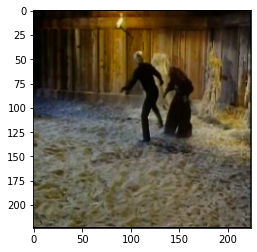

In [48]:
plt.imshow(visible_frame[3])

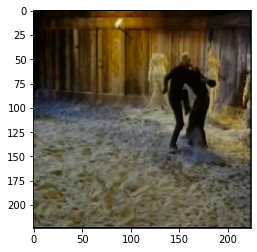

In [49]:
plt.imshow(visible_frame[49])

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

In [50]:
image_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 4s 0us/step


Let's see the model summary

In [51]:
image_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

I can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that I have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

In [52]:
input_shape = image_model.layers[0].output_shape[1:3]
print(input_shape)

[]


### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First I input and process 50 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, I save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then I can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values saved to a cache file, then I can use those transfer-values as the input to LSTM neural network. I will then train the second neural network using the classes from the violence dataset (Violence, No-Violence), so the network learns how to classify images based on the transfer-values from the VGG16 model.

In [53]:
# I will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


### Function to process 50 video frames through VGG16 and get transfer values

In [54]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that I use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

### Generator that process one video through VGG16 each function call

In [55]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that I use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([50,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

### Functions to save transfer values from VGG16 to later use
I am going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [56]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [57]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

Then I am going to process all video frames through VGG16 and save the transfer values.

In [58]:
make_files(training_set)

- Progress: 99.4%

In [59]:
make_files_test(test_set)

- Progress: 97.5%

Save the transfer values to Drive for later uses


In [60]:
drive_save_path = os.path.join('/mydrive/AIFinalProject_Group1/', dataset)
shutil.copy('prueba.h5', drive_save_path)
shutil.copy('pruebavalidation.h5', drive_save_path)

'/mydrive/AIFinalProject_Group1/movies_fights/pruebavalidation.h5'

### Load the cached transfer values into memory
I have already saved all the videos transfer values into disk. But I have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net. 


In order to load the saved transfer values into RAM memory I am going to use this two functions:

In [61]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=50
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [62]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=50
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [63]:
data, target = process_alldata_training()

In [64]:
data_test, target_test = process_alldata_test()

##Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which I will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which I will use in this tutorial.

A recurrent neuron has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.



### Define LSTM architecture

When defining the LSTM architecture I have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video I am processing 50 frames so I will have 50 x 4096 values per video. The classification must be done taking into account the 50 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 50. The second is the size of the features vector (transfer values).


In [65]:
chunk_size = 4096
n_chunks = 50
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['Accuracy'])

## Model training


In [66]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
1/1 - 3s - loss: 0.2629 - Accuracy: 0.5000 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.3677 - Accuracy: 0.5000 - 179ms/epoch - 179ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2567 - Accuracy: 0.5000 - 186ms/epoch - 186ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2449 - Accuracy: 0.5000 - 188ms/epoch - 188ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2463 - Accuracy: 0.5000 - 187ms/epoch - 187ms/step
Epoch 6/200
1/1 - 0s - loss: 0.2331 - Accuracy: 0.5188 - 191ms/epoch - 191ms/step
Epoch 7/200
1/1 - 0s - loss: 0.2298 - Accuracy: 0.5000 - 187ms/epoch - 187ms/step
Epoch 8/200
1/1 - 0s - loss: 0.2126 - Accuracy: 0.6500 - 188ms/epoch - 188ms/step
Epoch 9/200
1/1 - 0s - loss: 0.2031 - Accuracy: 0.6938 - 185ms/epoch - 185ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1760 - Accuracy: 0.9375 - 188ms/epoch - 188ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1590 - Accuracy: 0.8438 - 187ms/epoch - 187ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1462 - Accuracy: 0.8875 - 188ms/epoch - 188ms/step
Epoch 13/200
1/1 - 

In [67]:
model.save(drive_save_path + '/VGG16LSTM.h5')

## Print the model accuracy

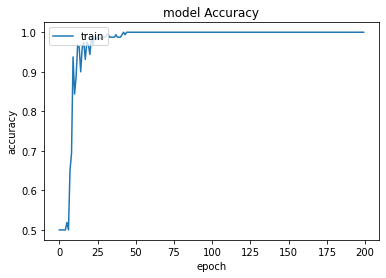

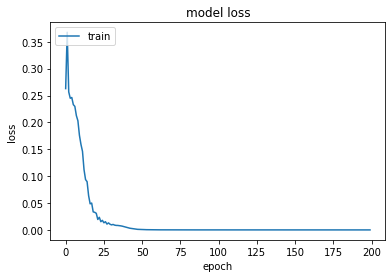

In [68]:
plt.plot(history.history['Accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('destination_path.svg', format='svg', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('destination_path1.svg', format='svg', dpi=1000)
plt.show()

## Test the model

## Test and evaluate the model

I am going to test and evaluate the model with 20 % of the total videos. This videos have not been used to train the network. 

### Test the model
Plese note that the transfer values of the testing set are used, not the test videos, for convinience

In [69]:
data_test, target_test = process_alldata_test()

predicted_labels = []
for i in range(len(data_test)):
  data_test[i] = np.expand_dims(data_test[i], axis=0)
  prediction = model.predict(data_test[i])[0]
  if prediction[1] > 0.9:
    predicted_labels.append([0.0, 1.0])
  else:
    predicted_labels.append([1.0, 0.0])

data_test, target_test = process_alldata_test()

### Evaluate the model

In [70]:
target_test1 = np.argmax(target_test, axis=1) # 0 for violence and 1 for non-violence
predicted_labels1 =np.argmax( predicted_labels, axis=1)
print(classification_report(target_test1, predicted_labels1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

